# Learn the globally optimal proposal for a linear gaussian state space model

We reproduce the experiment in Naesseth and al. Variational SMC

In [2]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pykalman
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2

seaborn.set()


In [3]:
tf.config.set_visible_devices([], 'GPU') 

In [4]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationModel

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.base import ProposalModelBase

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver, NaiveSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

### Set up the model

In [5]:
tf.random.set_seed(0)
np.random.seed(1)

T = 25

d_x = 10
d_y = 1
alpha = 0.42
gamma = 0.1

B = 10
N = 4

transition_matrix = np.array([[alpha**(abs(i-j) + 1) for j in range(d_x)] for i in range(d_x)], dtype=np.float32)
transition_covariance = gamma**2 * np.eye(d_x, dtype=np.float32)

observation_matrix = np.zeros([d_y, d_x], dtype=np.float32)
observation_matrix[:d_y, :d_y] = np.eye(d_y, dtype=np.float32)

observation_covariance = np.eye(d_y, dtype=np.float32)
# observation_matrix = np.ones([d_y, d_x], dtype=np.float32)
# observation_matrix = tf.random.normal([d_y, d_x], 0., 1.)


initial_state_mean = np.zeros(d_x, dtype=np.float32)
initial_state_covariance = np.eye(d_x, dtype=np.float32)

kf = pykalman.KalmanFilter(transition_matrix, observation_matrix, transition_covariance, observation_covariance, initial_state_mean=initial_state_mean, initial_state_covariance=initial_state_covariance)
observations = kf.sample(T)[1].data.astype(np.float32)

true_log_likelihood = kf.loglikelihood(observations)
true_log_likelihood

-38.2905492040977

In [6]:
observations_dataset = tf.data.Dataset.from_tensor_slices(observations)

### Set up the filterflow filter

In [7]:
transition_noise = tfd.MultivariateNormalDiag(tf.zeros(d_x, dtype=tf.float32), tf.linalg.diag_part(transition_covariance) ** 0.5) # mind it MultivariateNormalDiag does diag * diag...
transition_model = RandomWalkModel(tf.convert_to_tensor(transition_matrix), transition_noise)

In [8]:
observation_error = tfd.MultivariateNormalDiag(tf.zeros(d_y, dtype=tf.float32), tf.linalg.diag_part(observation_covariance) ** 0.5) # mind it MultivariateNormalDiag does diag * diag...
observation_model = LinearObservationModel(tf.convert_to_tensor(observation_matrix), observation_error)

In [9]:
class LearnableProposalModel(ProposalModelBase):
    def __init__(self, transition_matrix, name='LearnableProposalModel'):
        super(LearnableProposalModel, self).__init__(name=name)
        self._transition_matrix = transition_matrix
        self._standard_noise = tfd.MultivariateNormalDiag(tf.zeros(transition_matrix.shape[0]), tf.ones(transition_matrix.shape[0]))
    
    def propose(self, state: State, inputs, _observation: tf.Tensor):
        """See base class"""
        mu_t, beta_t, sigma_t = inputs
        
        transition_matrix = tf.linalg.matmul(tf.linalg.diag(beta_t), self._transition_matrix)
        
        pushed_particles = tf.reshape(mu_t, [1, 1, -1]) + tf.linalg.matvec(transition_matrix, state.particles)
        
        scale = tfp.bijectors.ScaleMatvecDiag(sigma_t)
        scaled_rv = tfd.TransformedDistribution(self._standard_noise, bijector=scale)        
        proposed_particles = pushed_particles + scaled_rv.sample([state.batch_size, state.n_particles])
        return attr.evolve(state, particles=proposed_particles)

    def loglikelihood(self, proposed_state: State, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        """Interface method for particle proposal
        :param proposed_state: State
            proposed state
        :param state: State
            previous particle filter state
        :param inputs: tf.Tensor
            Control variables (time elapsed, some environment variables, etc)
        :param observation: tf.Tensor
            Look ahead observation for adapted particle proposal
        :return: proposed State
        :rtype: tf.Tensor
        """            
        mu_t, beta_t, sigma_t = inputs
        transition_matrix = tf.linalg.matmul(tf.linalg.diag(beta_t), self._transition_matrix)
        pushed_particles = tf.reshape(mu_t, [1, 1, -1]) + tf.linalg.matvec(transition_matrix, state.particles)
        
        scale = tfp.bijectors.ScaleMatvecDiag(sigma_t)
        scaled_rv = tfd.TransformedDistribution(self._standard_noise, bijector=scale)
        
        diff = (pushed_particles - proposed_state.particles)
        return scaled_rv.log_prob(diff)

In [10]:
proposal_model = LearnableProposalModel(transition_matrix)
bootstrap_proposal = BootstrapProposalModel(transition_model)

In [11]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
resampling_method = MultinomialResampler() # SystematicResampler()

epsilon = tf.constant(0.5)
scaling = tf.constant(0.9)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)

solver = PetkovSolver(tf.constant(30))
corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4, ricatti_solver=solver, propagate_correction_gradient=False)

    
systematic_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, resampling_method)
regularized_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)
corrected_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, corrected)
bootstrap_smc = SMC(observation_model, transition_model, bootstrap_proposal, resampling_criterion, resampling_method)

In [12]:
initial_particles = tfd.MultivariateNormalDiag(initial_state_mean, tf.linalg.diag_part(initial_state_covariance)**0.5).sample([B, N])
uniform_weights = tf.ones([B, N])
uniform_weights = uniform_weights / tf.reduce_sum(uniform_weights, 1, keepdims=True)

uniform_log_weights = tf.math.log(uniform_weights)
log_likelihoods = tf.zeros([B])
init_state = State(initial_particles, uniform_log_weights, uniform_weights, log_likelihoods, None, None)

### Create the learnable variables that will be used as inputs to the proposal

In [13]:
scale = 0.5

mu_ts = tf.Variable(0.5 * tf.random.normal([T, d_x]), trainable=True)
beta_ts = tf.Variable(1. + scale * tf.random.normal([T, d_x]), trainable=True)
sigma_ts = tf.Variable(tf.math.exp(scale * tf.random.normal([T, d_x])), trainable=True)
# beta_ts = []
# sigma_ts = []
# for t in range(T):
#     mu_ts.append(tf.Variable(0., trainable=True))
#     beta_ts.append(tf.Variable(1., trainable=True))
#     sigma_ts.append(tf.Variable(gamma, trainable=True))
    


In [14]:
trainable_variables = [mu_ts, beta_ts, sigma_ts]

In [15]:
@tf.function
def smc_routine(smc, state, use_correction_term=False):
    iterator = iter(observations_dataset)
    for t in tf.range(T):
        mu_t = mu_ts[t]
        beta_t = beta_ts[t]
        sigma_t = sigma_ts[t]
        obs = iterator.get_next()
        state = smc.update(state, obs, [mu_t, beta_t, sigma_t])
        t = t + 1
    res = tf.reduce_mean(state.log_likelihoods)
    if use_correction_term:
        return res, tf.reduce_mean(state.resampling_correction)
    return res, tf.constant(0.)
    

In [16]:
test_bootstrap = [smc_routine(bootstrap_smc, init_state)[0].numpy().sum() for _ in range(100)] 

In [17]:
np.mean(test_bootstrap)

-41.09441

In [18]:
true_log_likelihood

-38.2905492040977

In [19]:
@tf.function
def train_one_step(optimizer, smc, use_correction_term):
    with tf.GradientTape() as tape:
        tape.watch(trainable_variables)
        real_ll, correction = smc_routine(smc, init_state, use_correction_term)
        loss = -(real_ll + correction)
    grads_loss = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads_loss, trainable_variables))
    return real_ll, grads_loss

@tf.function
def train(optimizer, smc, num_steps = 100, use_correction_term=False, reset=True):
    if reset:
        reset_operations = [mu_ts.assign(tf.zeros_like(mu_ts)), beta_ts.assign(tf.ones_like(beta_ts)), sigma_ts.assign(gamma * tf.ones_like(sigma_ts))]
    else:
        reset_operations = []
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies(reset_operations):
        tic = tf.timestamp()
        for step in tf.range(1, num_steps+1):
            real_ll, grads = train_one_step(optimizer, smc, use_correction_term)
            toc = tf.timestamp()
            max_grad = tf.reduce_max(tf.abs(grads))
            if step % (num_steps // 100) == 0:
                tf.print('Step', step, '/', num_steps, ': ms per step= ', 1000. * (toc - tic) / tf.cast(step, tf.float64), ': total time (s)= ', (toc - tic), ', log_likelihood = ', real_ll, ', max abs grads = ', max_grad, end='\r')
            loss_tensor_array = loss_tensor_array.write(step-1, real_ll)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
    return loss_tensor_array.stack(), grad_tensor_array.stack()

In [20]:
adam = tf.optimizers.Adam(lr = 1e-3)

In [21]:
tf.print(tf.reduce_mean(sigma_ts, 0))
tf.print(tf.reduce_mean(beta_ts, 0))
tf.print(tf.reduce_mean(mu_ts, 0))

[1.17442489 1.13127601 1.03404331 ... 1.36934006 1.25858665 1.01289976]
[0.940137148 0.879068434 1.09159863 ... 0.966803074 1.15960133 0.994477212]
[0.211283743 0.0128934691 -0.237645686 ... 0.122734033 0.0495563783 0.0404908434]


In [22]:
n_iter = 10000
ll, grads = train(adam, systematic_smc, tf.constant(n_iter))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [23]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

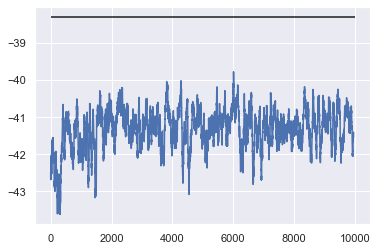

In [29]:
plt.plot(moving_average(ll.numpy(), 50))
plt.hlines(true_log_likelihood, 0, 10000)

In [25]:
tf.reduce_mean(beta_ts, 0)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.92050153, 0.92795134, 0.88678086, 0.87553334, 0.8390445 ,
       0.78702354, 0.81805605, 0.8685695 , 0.8865087 , 0.9242939 ],
      dtype=float32)>

In [26]:
tf.reduce_mean(sigma_ts, 0)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.10247049, 0.1010136 , 0.09832381, 0.1019046 , 0.10046874,
       0.1008432 , 0.10174166, 0.09858645, 0.10062486, 0.10021318],
      dtype=float32)>

In [27]:
tf.reduce_mean(mu_ts, 0)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.0066028 , -0.00452861, -0.00164163, -0.00015082,  0.00129783,
       -0.01219336, -0.0064563 , -0.00251127, -0.00078753, -0.00184873],
      dtype=float32)>

In [28]:
bootstrap_smc(init_state, observations_dataset, T)

FloatStateSeries(batch_size=<tf.Tensor: shape=(), dtype=int32, numpy=1>, n_particles=<tf.Tensor: shape=(), dtype=int32, numpy=4>, dimension=<tf.Tensor: shape=(), dtype=int32, numpy=10>, particles=<tf.Tensor: shape=(0, 1, 4, 10), dtype=float32, numpy=array([], shape=(0, 1, 4, 10), dtype=float32)>, log_weights=<tf.Tensor: shape=(0, 1, 4), dtype=float32, numpy=array([], shape=(0, 1, 4), dtype=float32)>, weights=<tf.Tensor: shape=(0, 1, 4), dtype=float32, numpy=array([], shape=(0, 1, 4), dtype=float32)>, log_likelihoods=<tf.Tensor: shape=(0, 1), dtype=float32, numpy=array([], shape=(0, 1), dtype=float32)>)